In [1]:
ors = 1

In [2]:
import sys
sys.path.append('../_amigocloud')
import simplekml
from amigocloud import AmigoCloud
import pandas as pd
from shapely import wkb
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
import os

In [5]:
# RUTA ONEDRIVE
ruta_data = r'C:\Documents'
# ruta de carpera donde estan las llaves
ruta = open('../ruta.txt')
ruta = ruta.readlines()[0]
# leer token
acceso = open(ruta + '/_keys/api_amigocloud.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

# leer los dos shps de siembra y puntos de planificacion
path_cat = ruta_data + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\catastro_S09_MIERCOLES.shp'
path_puntos = ruta_data + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\PUNTOS_PLAN.shp'
path_plan = ruta_data + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\PLANIFICACION.shp'
path_xlsx_parte = ruta_data + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\parte_diario_pulverizacion.xlsx'

# ACTUALIZAR SHP PLANIFICACION

In [6]:
gdf_puntos = gpd.read_file(path_puntos)
gdf_cat = gpd.read_file(path_cat)

In [7]:
# filtrar la semana de interes
gdf_puntos_select = gdf_puntos[gdf_puntos['os'] == ors]
gdf_puntos_sem = gdf_puntos_select.copy()
#quita caracteres especiales
gdf_puntos_sem['unidad_04'] = gdf_puntos_sem['unidad_04'].str.replace(r'[\r\n\t]', '', regex=True)
gdf_puntos_sem

,unidad_03,unidad_04,os,obs,procesado,geometry
0,41594,AGROPECUARIA CAMPO DULCE S.R.L.,1,NaN,NaN,"MULTIPOINT (500174.730 8096600.101, 501025.069..."


In [9]:
multipoint_gdf = gdf_puntos_sem.copy()

In [10]:
# Crear una lista para almacenar los nuevos registros de puntos individuales
point_records = []
# Iterar sobre cada registro en el GeoDataFrame original
for idx, row in multipoint_gdf.iterrows():
    multipoint_geom = row.geometry
    # Verificar si la geometría es de tipo multipunto
    if isinstance(multipoint_geom, MultiPoint):
        for point in multipoint_geom.geoms:
            # Crear un nuevo registro para cada punto individual
            new_record = row.copy()
            new_record.geometry = point
            point_records.append(new_record)
    else:
        # Si la geometría ya es un punto, simplemente añadir el registro original
        point_records.append(row)

# Crear un nuevo GeoDataFrame con los registros de puntos individuales
puntos_indi = gpd.GeoDataFrame(point_records, crs=multipoint_gdf.crs)

In [11]:
# puntos individuales
puntos_indi

,unidad_03,unidad_04,os,obs,procesado,geometry
0,41594,AGROPECUARIA CAMPO DULCE S.R.L.,1,NaN,NaN,POINT (500174.730 8096600.101)
0,41594,AGROPECUARIA CAMPO DULCE S.R.L.,1,NaN,NaN,POINT (501025.069 8094710.476)
0,41594,AGROPECUARIA CAMPO DULCE S.R.L.,1,NaN,NaN,POINT (501210.278 8095590.217)
0,41594,AGROPECUARIA CAMPO DULCE S.R.L.,1,NaN,NaN,POINT (501726.217 8095550.530)
0,41594,AGROPECUARIA CAMPO DULCE S.R.L.,1,NaN,NaN,POINT (502232.233 8094806.388)
0,41594,AGROPECUARIA CAMPO DULCE S.R.L.,1,NaN,NaN,POINT (502364.525 8095226.415)
0,41594,AGROPECUARIA CAMPO DULCE S.R.L.,1,NaN,NaN,POINT (502629.109 8094578.184)
0,41594,AGROPECUARIA CAMPO DULCE S.R.L.,1,NaN,NaN,POINT (502629.109 8095414.931)
0,41594,AGROPECUARIA CAMPO DULCE S.R.L.,1,NaN,NaN,POINT (502920.151 8094161.465)
0,41594,AGROPECUARIA CAMPO DULCE S.R.L.,1,NaN,NaN,POINT (503035.907 8094555.033)


<Axes: >

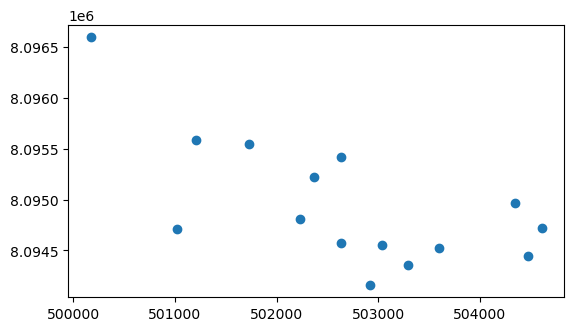

In [12]:
puntos_indi.plot()

In [13]:
# identifoca los lotes que se intersectan
gdf_lotes_cat = gpd.sjoin(gdf_cat, puntos_indi, how='inner', predicate='intersects')
# filtra los lotes intersectados en la capa original
poligonos_intersect_cat = gdf_cat.loc[gdf_cat.index.isin(gdf_lotes_cat.index)]
# copy
poligonos_intersect_cat = poligonos_intersect_cat.copy()
poligonos_intersect_cat = poligonos_intersect_cat[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'soca', 'zona', 'geometry']]

In [14]:
# Cambiar el nombre de la columna 'old_name' a 'new_name'
poligonos_intersect_cat.rename(columns={'zona': 'inst'}, inplace=True)

In [15]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry
10283,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L31,30.260942,2.0,50,"POLYGON ((504085.659 8094406.031, 503737.808 8..."
10284,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L16,23.216246,4.0,50,"POLYGON ((504352.053 8094797.970, 504272.088 8..."
10289,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L6,19.683505,5.0,50,"POLYGON ((503260.583 8094596.306, 503714.735 8..."
10290,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L35,7.795719,4.0,50,"POLYGON ((504693.348 8094607.629, 504673.327 8..."
10291,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L34,7.048921,5.0,50,"POLYGON ((504137.327 8094415.183, 504648.080 8..."
10292,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L5,10.318332,5.0,50,"POLYGON ((502800.712 8094558.618, 502817.481 8..."
10445,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L9,26.783587,3.0,50,"POLYGON ((502151.946 8095089.317, 502180.927 8..."
10541,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L15,17.950658,2.0,50,"POLYGON ((501079.860 8094856.577, 501419.672 8..."
10544,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L7,15.371285,2.0,50,"POLYGON ((501510.045 8095556.280, 501495.788 8..."
10548,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L10,26.586339,2.0,50,"POLYGON ((502549.761 8095663.451, 503187.898 8..."


In [16]:
# CAMBIAR NOMBRE DATOS DE UNIDAD_03 Y UNDIAD_04 DE LOTES SOLICITADOS A LO INDICADO EN LOS PUNTOS
# Iterar sobre cada punto y encontrar el polígono que intersecta
for idx, point in puntos_indi.iterrows():
    point_geom = point.geometry
    matching_polygons = poligonos_intersect_cat[poligonos_intersect_cat.intersects(point_geom)]
    
    # Actualizar los campos de los polígonos que intersectan con los valores del punto
    for poly_idx in matching_polygons.index:
        poligonos_intersect_cat.at[poly_idx, 'unidad_03'] = point['unidad_03']
        poligonos_intersect_cat.at[poly_idx, 'unidad_04'] = point['unidad_04']

In [17]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry
10283,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L31,30.260942,2.0,50,"POLYGON ((504085.659 8094406.031, 503737.808 8..."
10284,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L16,23.216246,4.0,50,"POLYGON ((504352.053 8094797.970, 504272.088 8..."
10289,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L6,19.683505,5.0,50,"POLYGON ((503260.583 8094596.306, 503714.735 8..."
10290,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L35,7.795719,4.0,50,"POLYGON ((504693.348 8094607.629, 504673.327 8..."
10291,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L34,7.048921,5.0,50,"POLYGON ((504137.327 8094415.183, 504648.080 8..."
10292,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L5,10.318332,5.0,50,"POLYGON ((502800.712 8094558.618, 502817.481 8..."
10445,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L9,26.783587,3.0,50,"POLYGON ((502151.946 8095089.317, 502180.927 8..."
10541,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L15,17.950658,2.0,50,"POLYGON ((501079.860 8094856.577, 501419.672 8..."
10544,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L7,15.371285,2.0,50,"POLYGON ((501510.045 8095556.280, 501495.788 8..."
10548,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L10,26.586339,2.0,50,"POLYGON ((502549.761 8095663.451, 503187.898 8..."


In [18]:
# agrega los campos faltantes
poligonos_intersect_cat['os'] = ors

In [19]:
plan = poligonos_intersect_cat.copy()

In [20]:
plan

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,os
10283,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L31,30.260942,2.0,50,"POLYGON ((504085.659 8094406.031, 503737.808 8...",1
10284,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L16,23.216246,4.0,50,"POLYGON ((504352.053 8094797.970, 504272.088 8...",1
10289,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L6,19.683505,5.0,50,"POLYGON ((503260.583 8094596.306, 503714.735 8...",1
10290,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L35,7.795719,4.0,50,"POLYGON ((504693.348 8094607.629, 504673.327 8...",1
10291,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L34,7.048921,5.0,50,"POLYGON ((504137.327 8094415.183, 504648.080 8...",1
10292,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L5,10.318332,5.0,50,"POLYGON ((502800.712 8094558.618, 502817.481 8...",1
10445,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L9,26.783587,3.0,50,"POLYGON ((502151.946 8095089.317, 502180.927 8...",1
10541,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L15,17.950658,2.0,50,"POLYGON ((501079.860 8094856.577, 501419.672 8...",1
10544,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L7,15.371285,2.0,50,"POLYGON ((501510.045 8095556.280, 501495.788 8...",1
10548,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L10,26.586339,2.0,50,"POLYGON ((502549.761 8095663.451, 503187.898 8...",1


<Axes: >

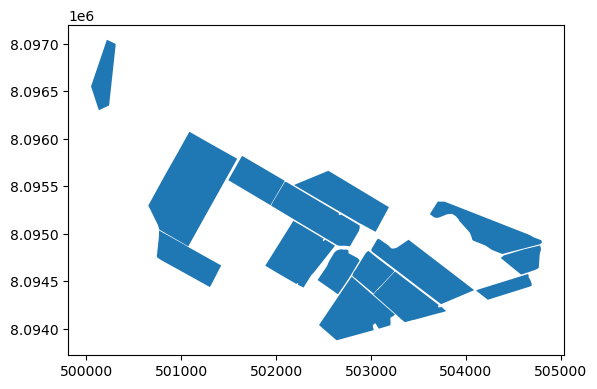

In [21]:
plan.plot()

In [22]:
plan['area'].sum()

322.21533398137024

In [23]:
#RECALCULAR EL AREA
plan['area'] = plan.geometry.area / 10000

In [24]:
plan['area'].sum()

322.2153339813142

In [25]:
# carga el shp de planificacion
gdf_plan = gpd.read_file(path_plan)

In [26]:
# determina el ultimo id
last_id = 0
if gdf_plan['id'].max() > 0:
    last_id = gdf_plan['id'].max()
else:
    last_id = 0

In [27]:
last_id

0

In [28]:
# Asignar valores incrementales a la columna 'id' empezando desde last_id + 1
plan['id'] = range(last_id + 1, last_id + 1 + len(plan))

In [29]:
plan

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,os,id
10283,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L31,30.260942,2.0,50,"POLYGON ((504085.659 8094406.031, 503737.808 8...",1,1
10284,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L16,23.216246,4.0,50,"POLYGON ((504352.053 8094797.970, 504272.088 8...",1,2
10289,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L6,19.683505,5.0,50,"POLYGON ((503260.583 8094596.306, 503714.735 8...",1,3
10290,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L35,7.795719,4.0,50,"POLYGON ((504693.348 8094607.629, 504673.327 8...",1,4
10291,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L34,7.048921,5.0,50,"POLYGON ((504137.327 8094415.183, 504648.080 8...",1,5
10292,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L5,10.318332,5.0,50,"POLYGON ((502800.712 8094558.618, 502817.481 8...",1,6
10445,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L9,26.783587,3.0,50,"POLYGON ((502151.946 8095089.317, 502180.927 8...",1,7
10541,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L15,17.950658,2.0,50,"POLYGON ((501079.860 8094856.577, 501419.672 8...",1,8
10544,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L7,15.371285,2.0,50,"POLYGON ((501510.045 8095556.280, 501495.788 8...",1,9
10548,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L10,26.586339,2.0,50,"POLYGON ((502549.761 8095663.451, 503187.898 8...",1,10


In [30]:
len(plan)

15

In [31]:
# union de los dos gdf
gdf_pla_gral = pd.concat([gdf_plan, plan], ignore_index=True)

C:\Users\bismarksr\AppData\Local\Temp\ipykernel_31388\364328693.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gdf_pla_gral = pd.concat([gdf_plan, plan], ignore_index=True)


In [32]:
gdf_pla_gral['area'].sum()

322.2153339813142

In [33]:
gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)

In [34]:
gdf_pla_gral

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,os,soca,id,inst,idd,geometry
0,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L31,30.260942,1,2,1,50,NaN,"POLYGON ((504085.659 8094406.031, 503737.808 8..."
1,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L16,23.216246,1,4,2,50,NaN,"POLYGON ((504352.053 8094797.970, 504272.088 8..."
2,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L6,19.683505,1,5,3,50,NaN,"POLYGON ((503260.583 8094596.306, 503714.735 8..."
3,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L35,7.795719,1,4,4,50,NaN,"POLYGON ((504693.348 8094607.629, 504673.327 8..."
4,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L34,7.048921,1,5,5,50,NaN,"POLYGON ((504137.327 8094415.183, 504648.080 8..."
5,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L5,10.318332,1,5,6,50,NaN,"POLYGON ((502800.712 8094558.618, 502817.481 8..."
6,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L9,26.783587,1,3,7,50,NaN,"POLYGON ((502151.946 8095089.317, 502180.927 8..."
7,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L15,17.950658,1,2,8,50,NaN,"POLYGON ((501079.860 8094856.577, 501419.672 8..."
8,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L7,15.371285,1,2,9,50,NaN,"POLYGON ((501510.045 8095556.280, 501495.788 8..."
9,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L10,26.586339,1,2,10,50,NaN,"POLYGON ((502549.761 8095663.451, 503187.898 8..."


In [35]:
# exportar los datos en nuevo shp
gdf_pla_gral.to_file(path_plan)

# CARGAR PLANIFICACION A AMIGOCLOUD

In [36]:
def convertir_a_multipolygon(geometry):
    if isinstance(geometry, Polygon):
        return MultiPolygon([geometry])
    return geometry

def convertir_a_wkb(polygon):
    wkb_data = wkb.dumps(polygon, hex=True)
    return wkb_data

In [37]:
# repreyectar a WGS84
gdf_pla_gral = plan.to_crs(epsg=4326)
# convertir poligonos a multipoligonos
gdf_pla_gral['geometry'] = gdf_pla_gral['geometry'].apply(convertir_a_multipolygon)

In [38]:
gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)

In [39]:
len(gdf_pla_gral)

15

In [40]:
# recorrer el gdf de lotes y cargarlo a amigocloud
id_proyecto = f'https://app.amigocloud.com/api/v1/projects/35248/sql'
for index, row in gdf_pla_gral.iterrows():
    wkb_hex = convertir_a_wkb(row['geometry'])
    insert_sql = f"""
    INSERT INTO dataset_360912 (id, unidad_01, unidad_02, unidad_03, unidad_04, unidad_05, area, os, geometry)
    VALUES ({row['id']}, {row['unidad_01']}, '{row['unidad_02']}', {row['unidad_03']}, '{row['unidad_04']}', '{row['unidad_05']}', {row['area']}, '{row['os']}', ST_SetSRID(ST_GeomFromWKB('\\x{wkb_hex}'), 4326));
    """
    query_sql = {'query': insert_sql}
    resultado_post = amigocloud.post(id_proyecto, query_sql)

# CARGAR XLSX

In [48]:
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from datetime import datetime

In [49]:
# Cargar el archivo Excel
sheet_name = 'DATA'
table_name = 'tbl_data'

In [50]:
excel_data = pd.read_excel(path_xlsx_parte)

In [46]:
gdf_pla_gral

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,os,id
10283,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L31,30.260942,2,50,"MULTIPOLYGON (((-62.96157 -17.23537, -62.96484...",1,1
10284,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L16,23.216246,4,50,"MULTIPOLYGON (((-62.95906 -17.23183, -62.95982...",1,2
10289,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L6,19.683505,5,50,"MULTIPOLYGON (((-62.96933 -17.23366, -62.96506...",1,3
10290,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L35,7.795719,4,50,"MULTIPOLYGON (((-62.95585 -17.23355, -62.95604...",1,4
10291,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L34,7.048921,5,50,"MULTIPOLYGON (((-62.96108 -17.23529, -62.95628...",1,5
10292,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L5,10.318332,5,50,"MULTIPOLYGON (((-62.97366 -17.23400, -62.97350...",1,6
10445,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L9,26.783587,3,50,"MULTIPOLYGON (((-62.97976 -17.22920, -62.97949...",1,7
10541,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L15,17.950658,2,50,"MULTIPOLYGON (((-62.98984 -17.23130, -62.98665...",1,8
10544,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L7,15.371285,2,50,"MULTIPOLYGON (((-62.98580 -17.22498, -62.98593...",1,9
10548,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L10,26.586339,2,50,"MULTIPOLYGON (((-62.97602 -17.22401, -62.97001...",1,10


In [53]:
new_data = {
    'INSTITUCION':list(gdf_pla_gral['inst']), 
    'COD CANERO': list(gdf_pla_gral['unidad_03']),
    'NOMBRE CANERO': list(gdf_pla_gral['unidad_04']),
    'COD PROPIEDAD': list(gdf_pla_gral['unidad_01']),
    'NOMBRE PROPIEDAD': list(gdf_pla_gral['unidad_02']),
    'LOTE': list(gdf_pla_gral['unidad_05']),
    'HECTAREA': list(gdf_pla_gral['area']),
    'CICLO': list(gdf_pla_gral['soca']),
    'ID': list(gdf_pla_gral['id']),
    'OS': list(gdf_pla_gral['os'])
}

new_df = pd.DataFrame(new_data)

In [54]:
new_df

,INSTITUCION,COD CANERO,NOMBRE CANERO,COD PROPIEDAD,NOMBRE PROPIEDAD,LOTE,HECTAREA,CICLO,ID,OS
0,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,30,CAMPO DULCE,EP-L31,30.260942,2,1,1
1,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,30,CAMPO DULCE,EP-L16,23.216246,4,2,1
2,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,30,CAMPO DULCE,ER-L6,19.683505,5,3,1
3,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,30,CAMPO DULCE,EP-L35,7.795719,4,4,1
4,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,30,CAMPO DULCE,EP-L34,7.048921,5,5,1
5,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,30,CAMPO DULCE,ER-L5,10.318332,5,6,1
6,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,30,CAMPO DULCE,ER-L9,26.783587,3,7,1
7,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,30,CAMPO DULCE,ER-L15,17.950658,2,8,1
8,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,30,CAMPO DULCE,EP-L7,15.371285,2,9,1
9,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,30,CAMPO DULCE,EP-L10,26.586339,2,10,1


In [57]:
new_df['MEZCLA'] = 0
new_df['LABOR_REALIZADA'] = 'PUL. CON DRONE'
new_df['Nº DE LABOR'] = 'PA-2025-1'

In [58]:
new_df

,INSTITUCION,COD CANERO,NOMBRE CANERO,COD PROPIEDAD,NOMBRE PROPIEDAD,LOTE,HECTAREA,CICLO,ID,OS,MEZCLA,LABOR_REALIZADA,Nº DE LABOR
0,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,30,CAMPO DULCE,EP-L31,30.260942,2,1,1,0,PUL. CON DRONE,PA-2025-1
1,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,30,CAMPO DULCE,EP-L16,23.216246,4,2,1,0,PUL. CON DRONE,PA-2025-1
2,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,30,CAMPO DULCE,ER-L6,19.683505,5,3,1,0,PUL. CON DRONE,PA-2025-1
3,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,30,CAMPO DULCE,EP-L35,7.795719,4,4,1,0,PUL. CON DRONE,PA-2025-1
4,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,30,CAMPO DULCE,EP-L34,7.048921,5,5,1,0,PUL. CON DRONE,PA-2025-1
5,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,30,CAMPO DULCE,ER-L5,10.318332,5,6,1,0,PUL. CON DRONE,PA-2025-1
6,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,30,CAMPO DULCE,ER-L9,26.783587,3,7,1,0,PUL. CON DRONE,PA-2025-1
7,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,30,CAMPO DULCE,ER-L15,17.950658,2,8,1,0,PUL. CON DRONE,PA-2025-1
8,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,30,CAMPO DULCE,EP-L7,15.371285,2,9,1,0,PUL. CON DRONE,PA-2025-1
9,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,30,CAMPO DULCE,EP-L10,26.586339,2,10,1,0,PUL. CON DRONE,PA-2025-1


In [59]:
final_data = pd.concat([excel_data, new_df], ignore_index=True)

C:\Users\bismarksr\AppData\Local\Temp\ipykernel_31388\1827303315.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat([excel_data, new_df], ignore_index=True)


In [60]:
final_data.to_excel(path_xlsx_parte, index=False)